# Import packages

In [1]:
from array import array
import itertools
import time
import math

import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting.style import get_style, set_style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import matplotlib.pyplot as plt
import numpy as np

import astroML.plotting as aml
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter

Welcome to JupyROOT 6.13/01


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


# File

In [2]:
#RootFile = "Same_Event_Correlation.root"
#RootFile = "Same_Event_Correlation_TPC_ISO.root"
#RootFile = "Mix_Event_Correlation.root"
#RootFile = "Same_Event_Correlation_TPC_ISO.root"
RootFile = 'Same_Mix_Ratio.root'

# Define Bins

In [3]:
#FIXME: Read from Corr_config.yaml
zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
pTbins = [10, 11, 12.5, 16]

## Plot Titles

In [4]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    histo.SetTitle("Mix Corrected #gamma-hadron: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
                   %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{1}{N_{Trig}} #frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitle("#frac{d^{2}N}{d#phid#eta}")
    histo.GetYaxis().SetTitleOffset(1.35)
    ROOT.gStyle.SetOptStat("");
    if not(DNN_Bool):
        histo.SetLineColor(2)

<sup> **Note** Scaling is done cell by cell (despite Axis title here) for accurate subtraction<sup>

# ZYAM

In [5]:
def Subtract_ZYAM (PhiProjection):
    zyam = PhiProjection.Integral(11,13)/3
    for i in range(25):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

In [6]:
def ZYAM_Line(hsig):
    zyam_value = hsig.Integral(11,13)/3
    ZYAM = ROOT.TLine(-math.pi/2,zyam_value,3*math.pi/2,zyam_value)
    ZYAM.SetLineColorAlpha(7, 0.9)
    ZYAM.SetLineWidth(3)
    SetOwnership(ZYAM, 0)
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    legend.AddEntry(ZYAM, "ZYAM","l")
    SetOwnership(legend, 0) # 0 = release (not keep), 1 = keep
    return ZYAM,legend

## N Triggers

In [7]:
def Get_NTriggers(filename, ipt, Signal_DNN=True):
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) 
    file = ROOT.TFile(filename)
    ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

## Large $\eta$

In [8]:
def Large_Eta(filename, ipt, izt, Signal_DNN=True):
    
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    #Project
    Eta_Axis = histo2D.GetYaxis()
    LE_Projection = histo2D.ProjectionX('Large_Eta', Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8));
    LE_Projection_Pos = histo2D.ProjectionX('Large_Eta_Pos', Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4));
    
    #Add,Scale
    LE_Projection.Add(LE_Projection_Pos,1)
    LE_Projection.Scale(1.0/1.2)
    LE_Projection.SetDirectory(0)
    ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)
    LE_Projection.Scale(1.0/ntriggers)
    Plot1D(LE_Projection,ipt,izt,Signal_DNN) 
    
    #Legend
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    LE_Projection.SetLineColorAlpha(8,0.9)
    legend.AddEntry(LE_Projection, "|#eta| > 0.8","l")
    return LE_Projection,legend

In [9]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    #Project
    Eta_Axis = histo2D.GetYaxis()
    LE_PhiProjection = histo2D.ProjectionX('LargeEta_DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(1.4))
    
    PhiProjection_neg = histo2D.ProjectionX('SmallEta_DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-0.8),Eta_Axis.FindBin(0.8))
    #Add,scale 
    LE_PhiProjection.SetDirectory(0)
    LE_PhiProjection.Add(PhiProjection_neg,-1)
    LE_PhiProjection.Scale(1.0/1.2) #scale by eta region
    ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)    
    if not(ntriggers == None):
        LE_PhiProjection.Scale(1.0/ntriggers) #per trigger yield
    Plot1D(LE_PhiProjection,ipt,izt,Signal_DNN)
        
    #Legend
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    LE_PhiProjection.SetLineColorAlpha(8,0.9)
    legend.AddEntry(LE_PhiProjection, "|#eta| > 0.8","l")
    file.Close()
    return LE_PhiProjection,legend

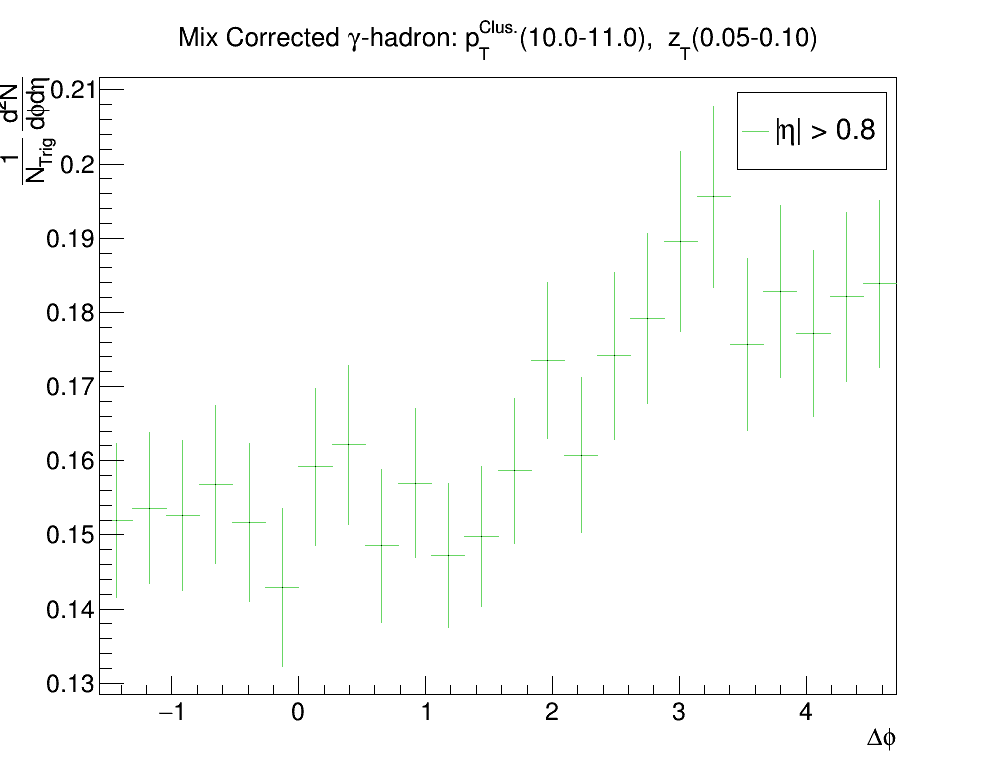

In [10]:
LE,legend = GetLEProj(RootFile, 0, 0, True)
cav = ROOT.TCanvas("cav","cav", 1000,800)
LE.Draw()
legend.Draw()
cav.Draw()

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [11]:
def GetPhiProj(filename, ipt, izt, Signal_DNN=True, doZYAM=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    #integral
    Eta_Axis = histo2D.GetYaxis()
    bin1 = Eta_Axis.FindBin(-0.6)
    PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                    #10*zTbins[izt+1]),5,11)
    PhiProjection.SetDirectory(0)
    PhiProjection.Scale(1.0/1.2) #scale by eta region

    ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)    
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        Subtract_ZYAM(PhiProjection)
    
    file.Close()
    print(PhiProjection.GetEntries())
    return PhiProjection

<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

### Side By Side

105335.293836
144348.461425
29833.3926864
40778.9870491
6645.23166815
9751.59622089
902.247011885
1774.42725414
288.65277533
595.354975079
70.5422068563
173.663032743


INFO:ROOT.TCanvas.Print] png file pics/ZYAM_per_Trigger.png has been created


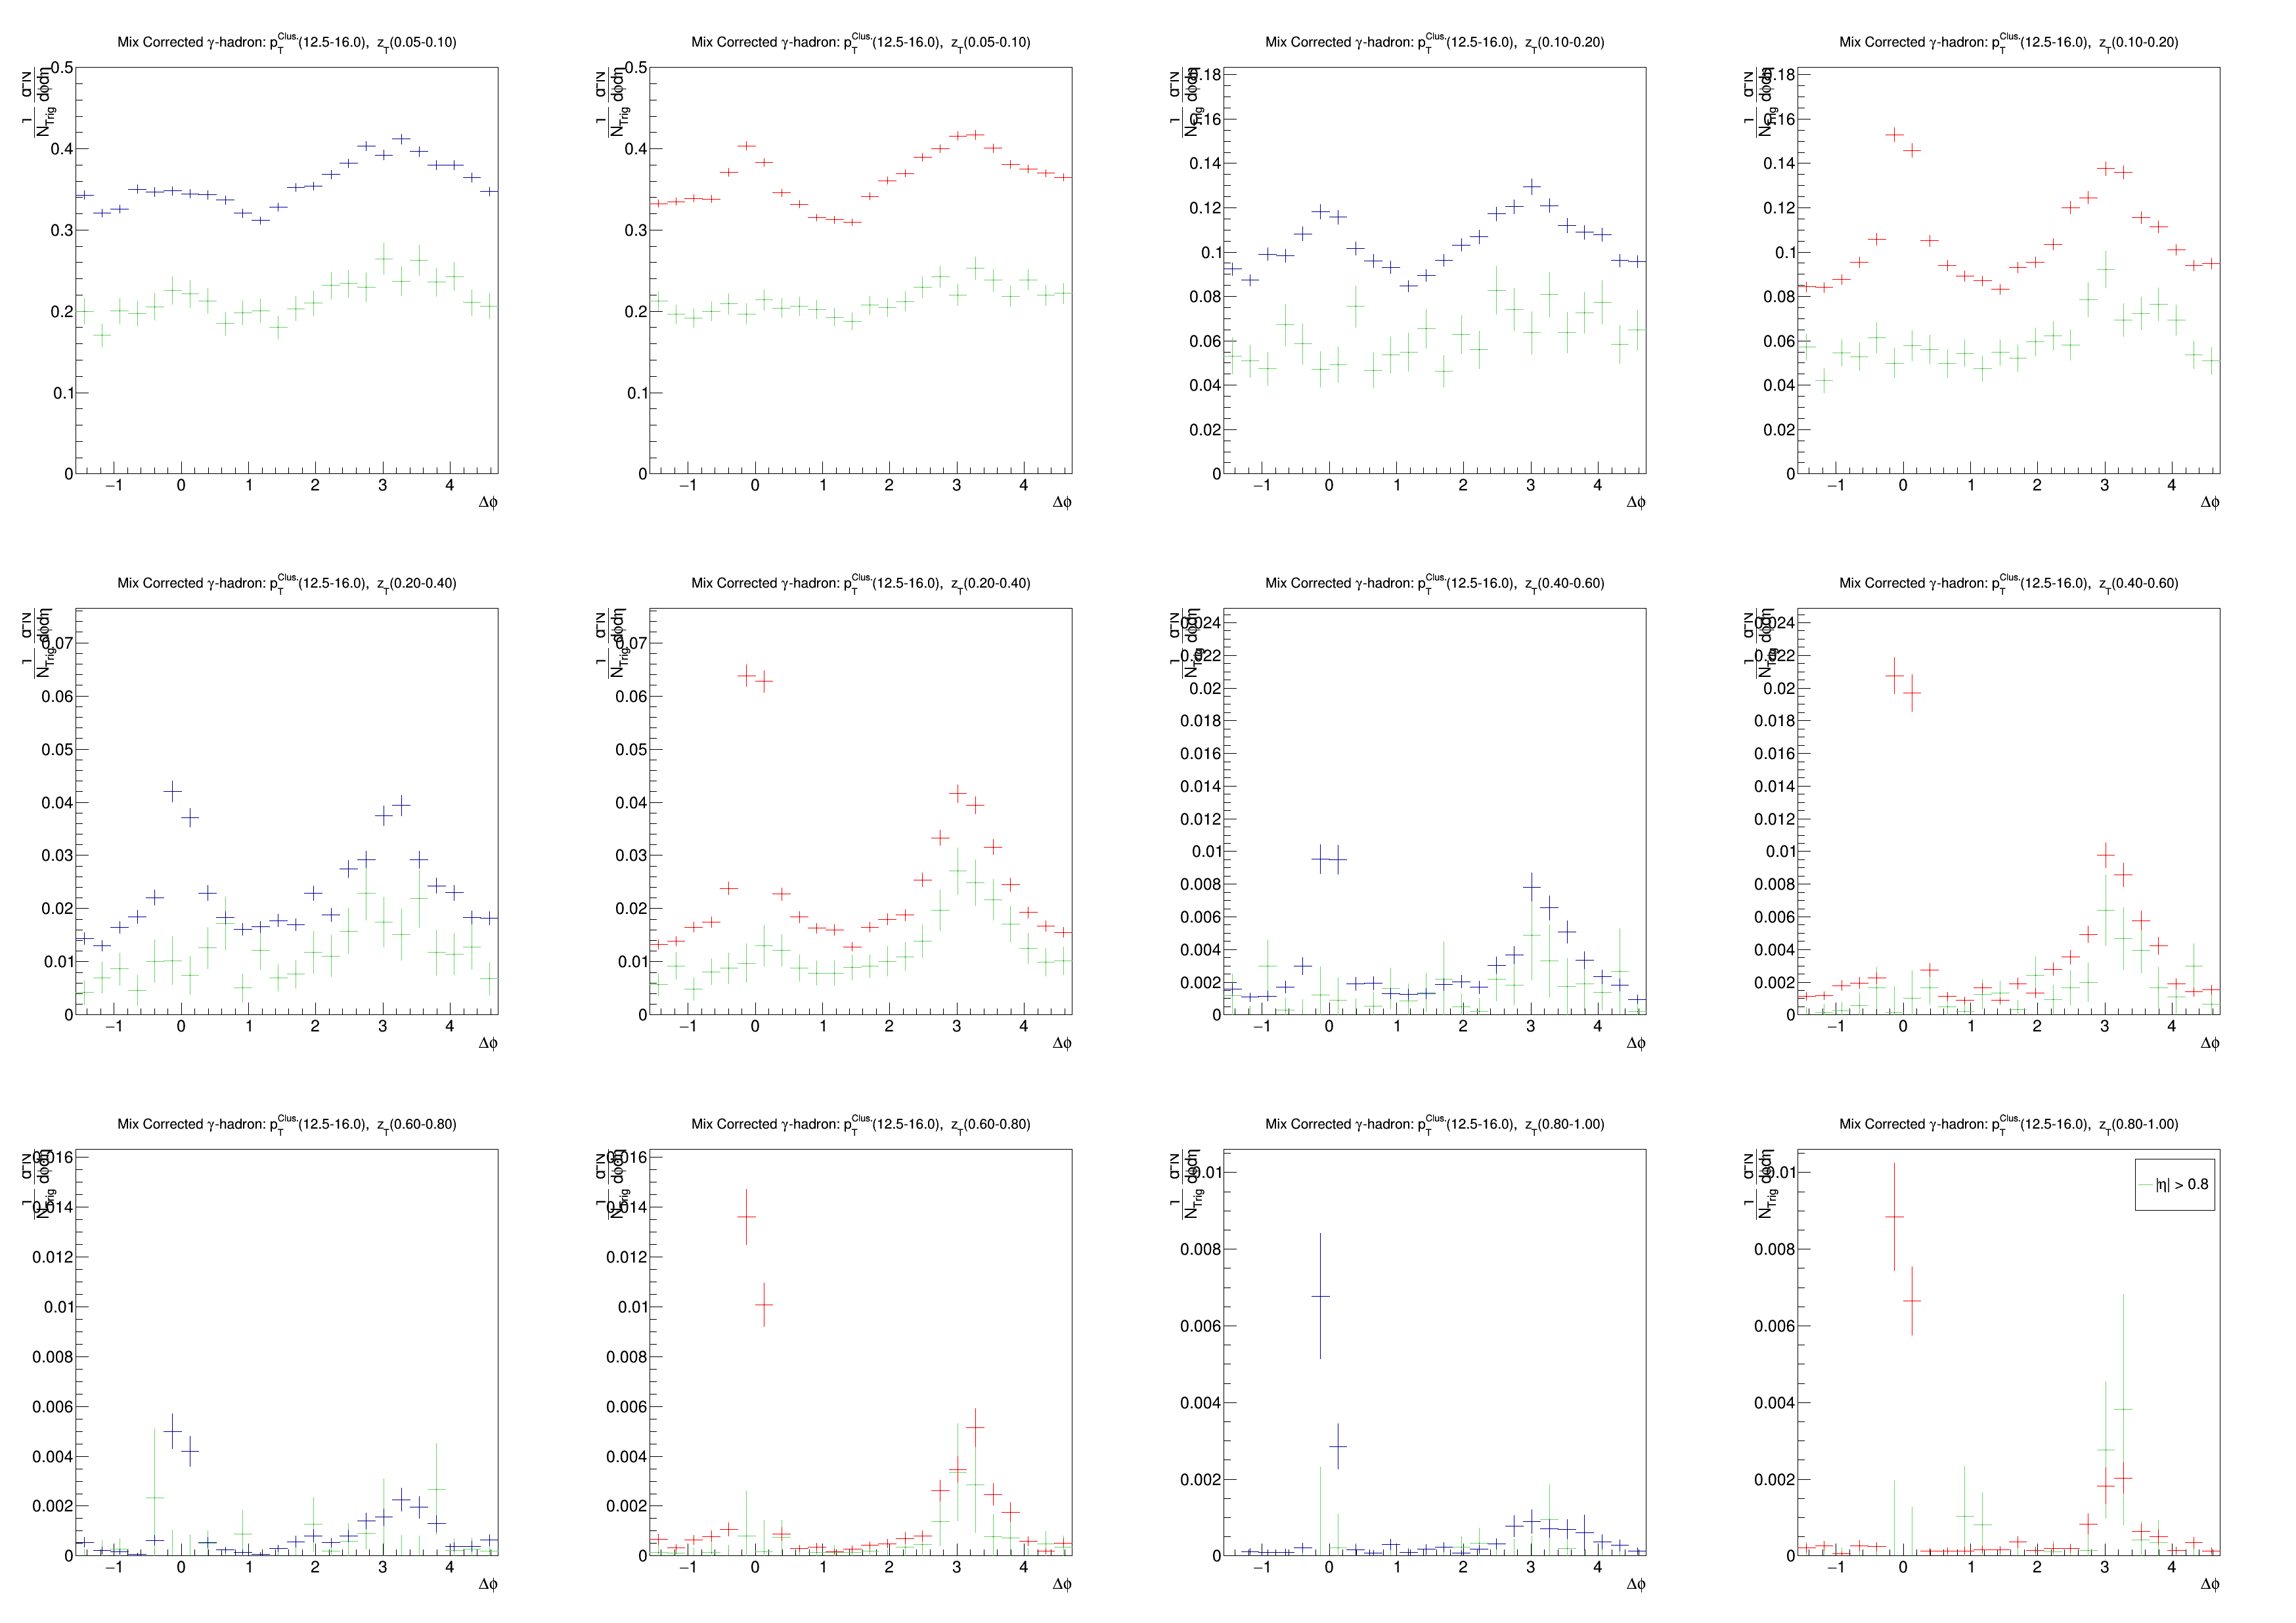

In [22]:
canvases = ROOT.TCanvas("canv_phi","canv_phi",3500,2500)
canvases.Divide(4,3)
ptbin = 2

for ztbin in range(6):
    
    #grab and scale
    hsig = GetPhiProj(RootFile,ptbin,ztbin,True,False)
    hbkg = GetPhiProj(RootFile,ptbin,ztbin,False,False)
    #hsig.Scale(1.0/Get_NTriggers(RootFile,0,True))
    #hbkg.Scale(1.0/Get_NTriggers(RootFile,0,False))
 
    #same scale
    ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
    hsig.GetYaxis().SetRangeUser(0,ymax)
    hbkg.GetYaxis().SetRangeUser(0,ymax)    
    
    #Signal
    canvases.cd(ztbin*2+1)
    hsig.Draw()
    #Sig_ZYAM,legend = ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
    #Sig_ZYAM.Draw("same")
    LE_sig,legend = GetLEProj(RootFile, ptbin, ztbin,True)
    LE_sig.Draw("same")
    hsig.Draw("same")
    legend.AddEntry(hsig)
    legend.Draw("same")
    
    #Background
    canvases.cd(ztbin*2+2)
    hbkg.Draw()
    LE_bkg,legend = GetLEProj(RootFile, ptbin, ztbin, False)
    #BKG_ZYAM,legend = ZYAM_Line(hbkg)
    #BKG_ZYAM.Draw("same")
    LE_bkg.Draw("same")
    hbkg.Draw("same")
    legend.Draw("same")
    
canvases.Draw()   
canvases.SaveAs("pics/ZYAM_per_Trigger.png")

# Purity Scaling and Subtraction

In [13]:
def GetBKGsubtracted(filename, ptbin, ztbin, doZYAM=True, doSubtraction=True):
    Signal = GetPhiProj(filename,ptbin,ztbin,True,doZYAM) #High DNN (True)
    Background = GetPhiProj(filename,ptbin,ztbin,False,doZYAM) #Low DNN (False)
    purity = 0.35
    N1 = Get_NTriggers(filename, ptbin, True)
    N2 = Get_NTriggers(filename, ptbin, False)
    #Background.Scale((1-purity)*N1/N2)
    Background.Scale((1-purity))
   
    if (doSubtraction):
        Signal.Add(Background,-1)
        #Root handles errors correctly. Have checked with manual quadrature sum
    
    #Signal.Scale(1.0/N1*purity)
    #Background.Scale(1.0/N1*purity)
    Signal.Scale(1.0/purity)
    Background.Scale(1.0/purity)
    
    Signal.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    Background.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    return Signal,Background

#### Subtraction: $\frac{C_1-\frac{C_2}{N_2}\cdot N_1\cdot(1-p)}{N_1\cdot p}$

# Loop and Plot

In [14]:
def Looping(filename,DoZYAM,DoSub=True):
    canvases = []
    for ptbin in range(3):
        canvases.append(ROOT.TCanvas("canv%i"%(ptbin),"canv",2500,2000))
        canvases[ptbin].Divide(2,3)
        for ztbin in range(6):
            hsig,hbkg = GetBKGsubtracted(filename,ptbin,ztbin,DoZYAM,DoSub)#doZYAM,doSubtraction
            canvases[ptbin].cd(ztbin+1)             

            ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
            ymin = -2*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
            hsig.GetYaxis().SetRangeUser(ymin,ymax)
            hbkg.GetYaxis().SetRangeUser(ymin,ymax)            
            hsig.Draw()

            #Overlay
            if not(DoSub): 
                hbkg.Draw("same")
                canvases[ptbin].Update()
                legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
                legend.AddEntry(hsig, "0.55 < DNN < 0.85","l")
                legend.AddEntry(hbkg, "0.0 < DNN < 0.3","l")
                SetOwnership(legend, 0) # 0 = release (not keep), 1 = keep
                legend.Draw("same")
            canvases[ptbin].Draw()
  
        if (DoSub): canvases[ptbin].SaveAs('pics/correlations_Subtracted_ptbin%i.png'%(ptbin))
        else: canvases[ptbin].SaveAs('pics/correlations_Overlay_ptbin%i.png'%(ptbin))
    return canvases

INFO:ROOT.TCanvas.Print] png file pics/correlations_Overlay_ptbin0.png has been created


103799.92022
56357.4705753
55276.673704
31093.5306318
15562.8144657
9345.08874955
2172.97082617
1737.51507128
689.63780453
556.055719807
311.189920058
236.770805545


129196.394898
82801.4952702
53433.8636273
35224.6804557
13189.0785113
9570.5341526
1862.11517803
1702.01111125
586.428775997
572.245658723
248.670388774
254.461547044


INFO:ROOT.TCanvas.Print] png file pics/correlations_Overlay_ptbin1.png has been created
INFO:ROOT.TCanvas.Print] png file pics/correlations_Overlay_ptbin2.png has been created


105360.293836
144373.461425
29858.3926864
40803.9870491
6670.23166815
9776.59622089
927.247011885
1799.42725414
313.65277533
620.354975079
95.5422068563
198.663032743


[<ROOT.TCanvas object ("canv0") at 0x7f862ed64640>,
 <ROOT.TCanvas object ("canv1") at 0x7f862ee79970>,
 <ROOT.TCanvas object ("canv2") at 0x7f862ee5fcc0>]

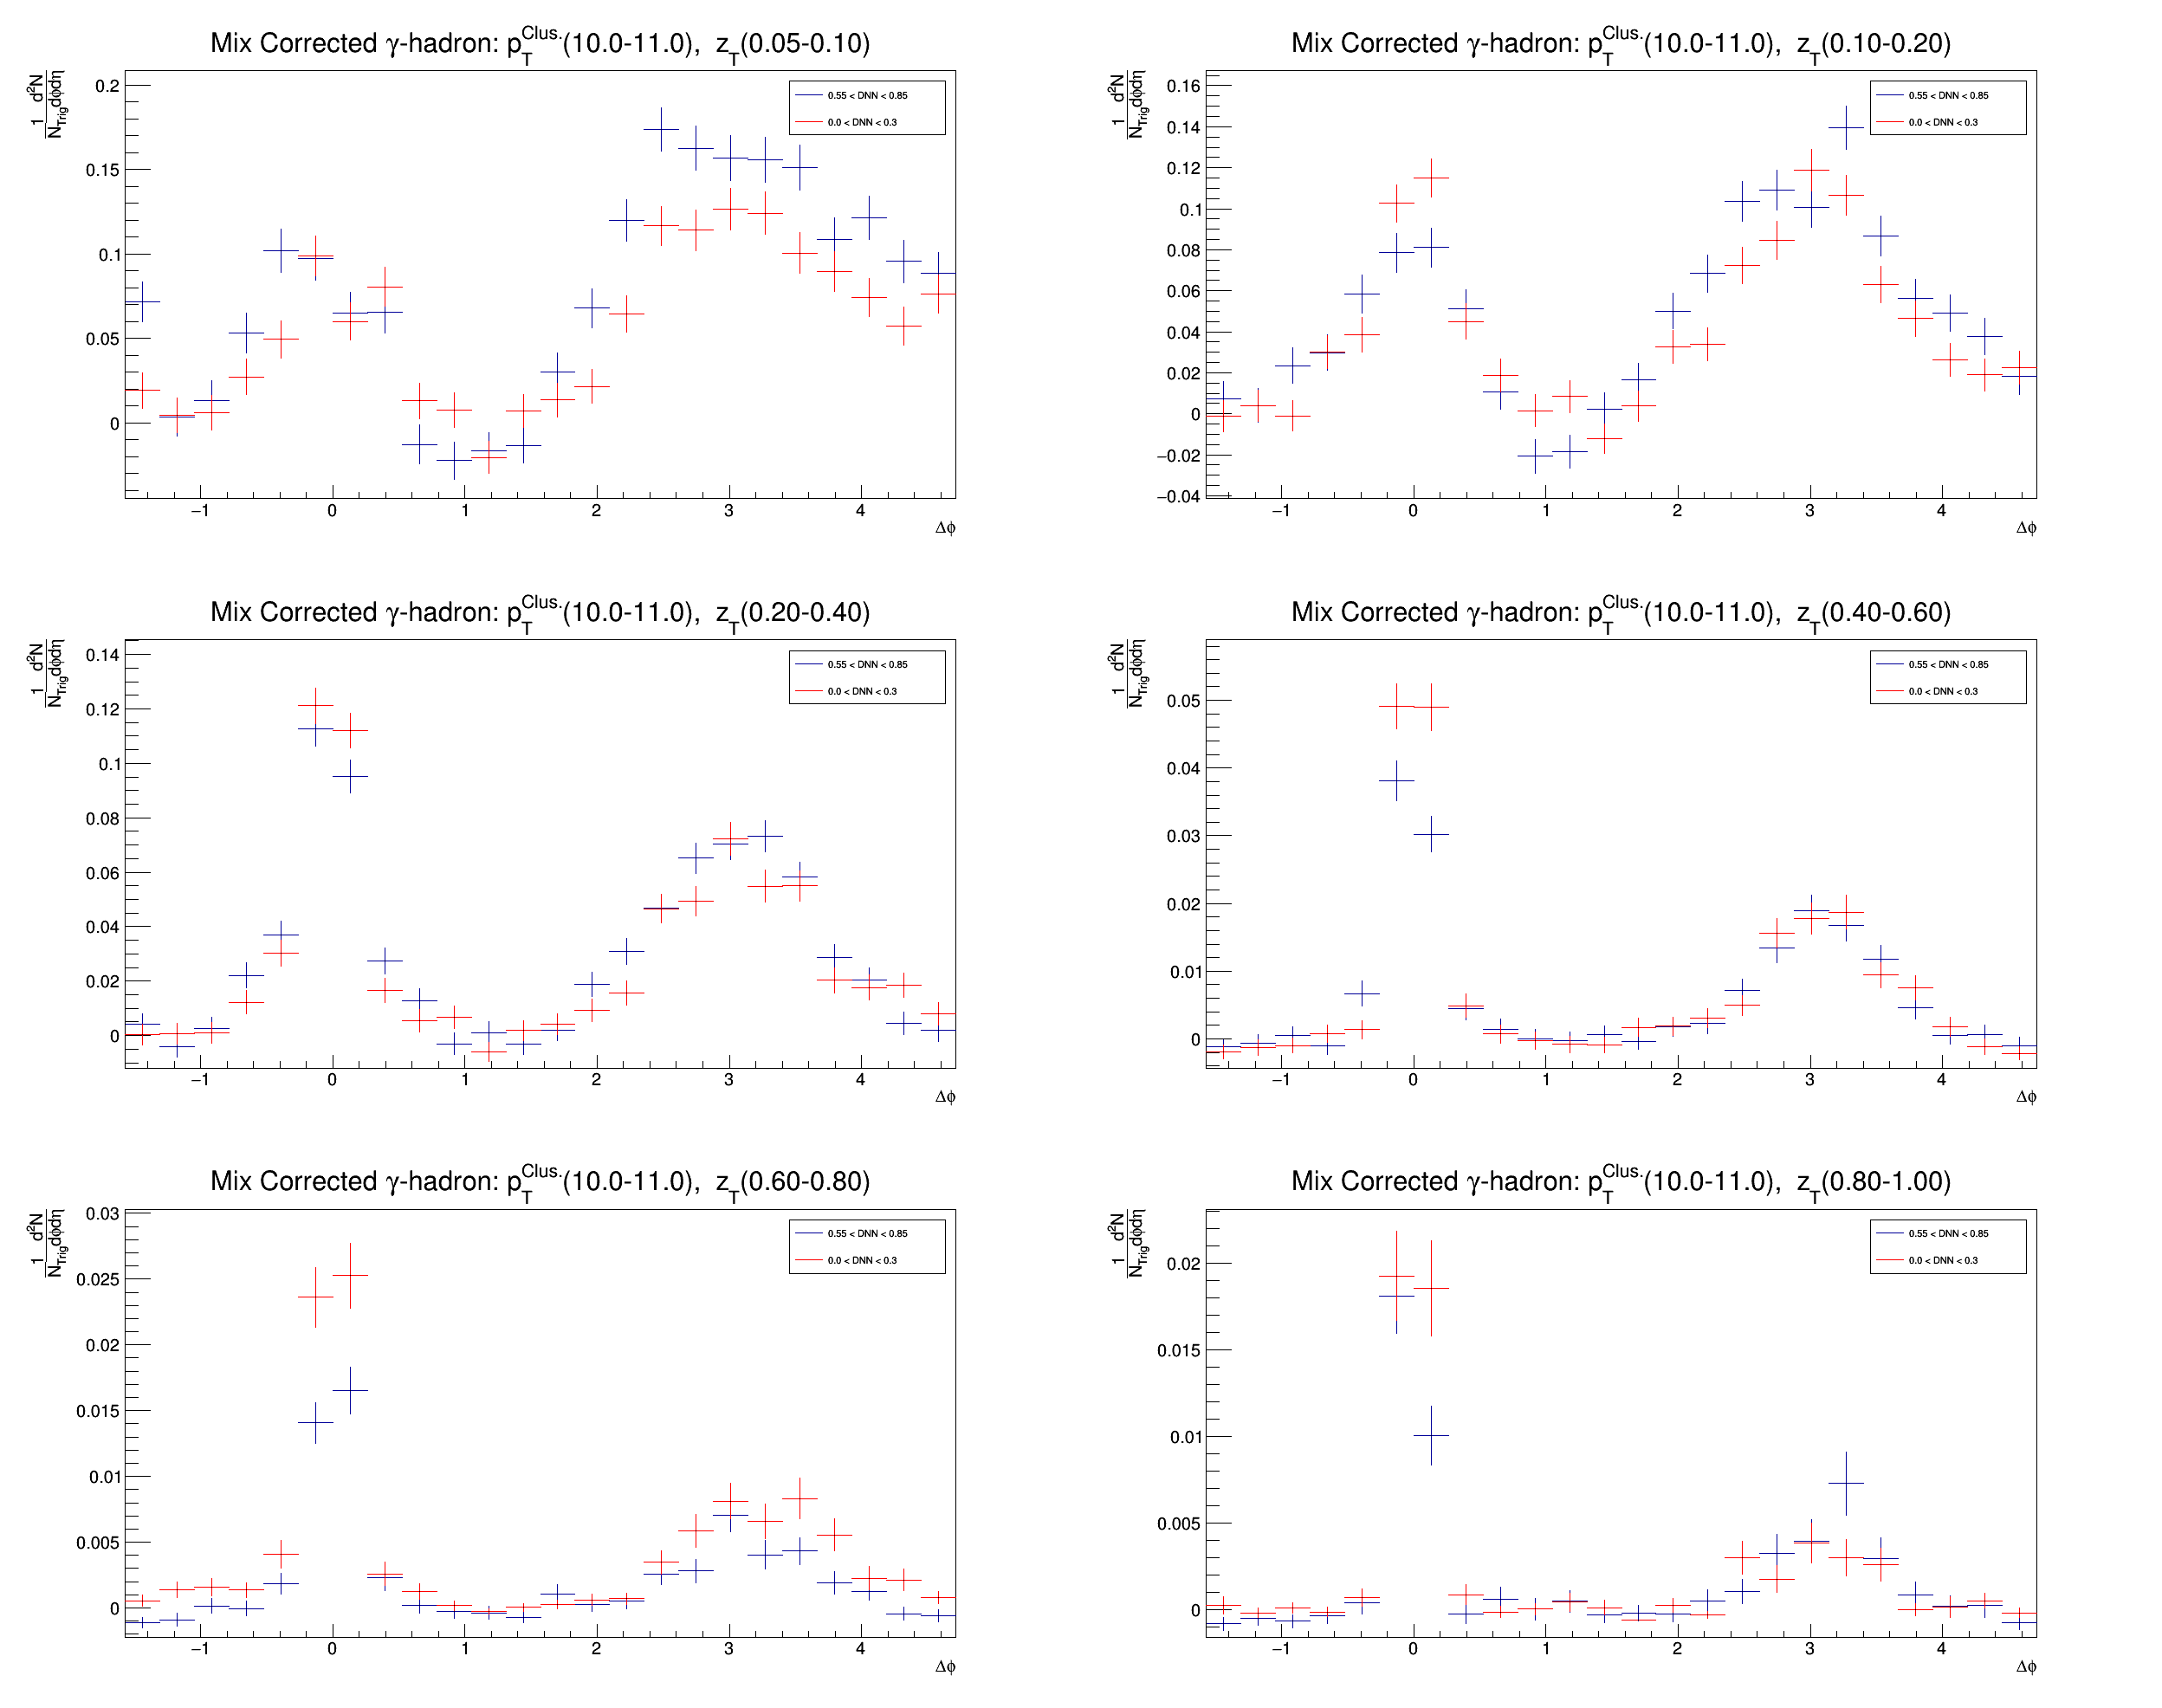

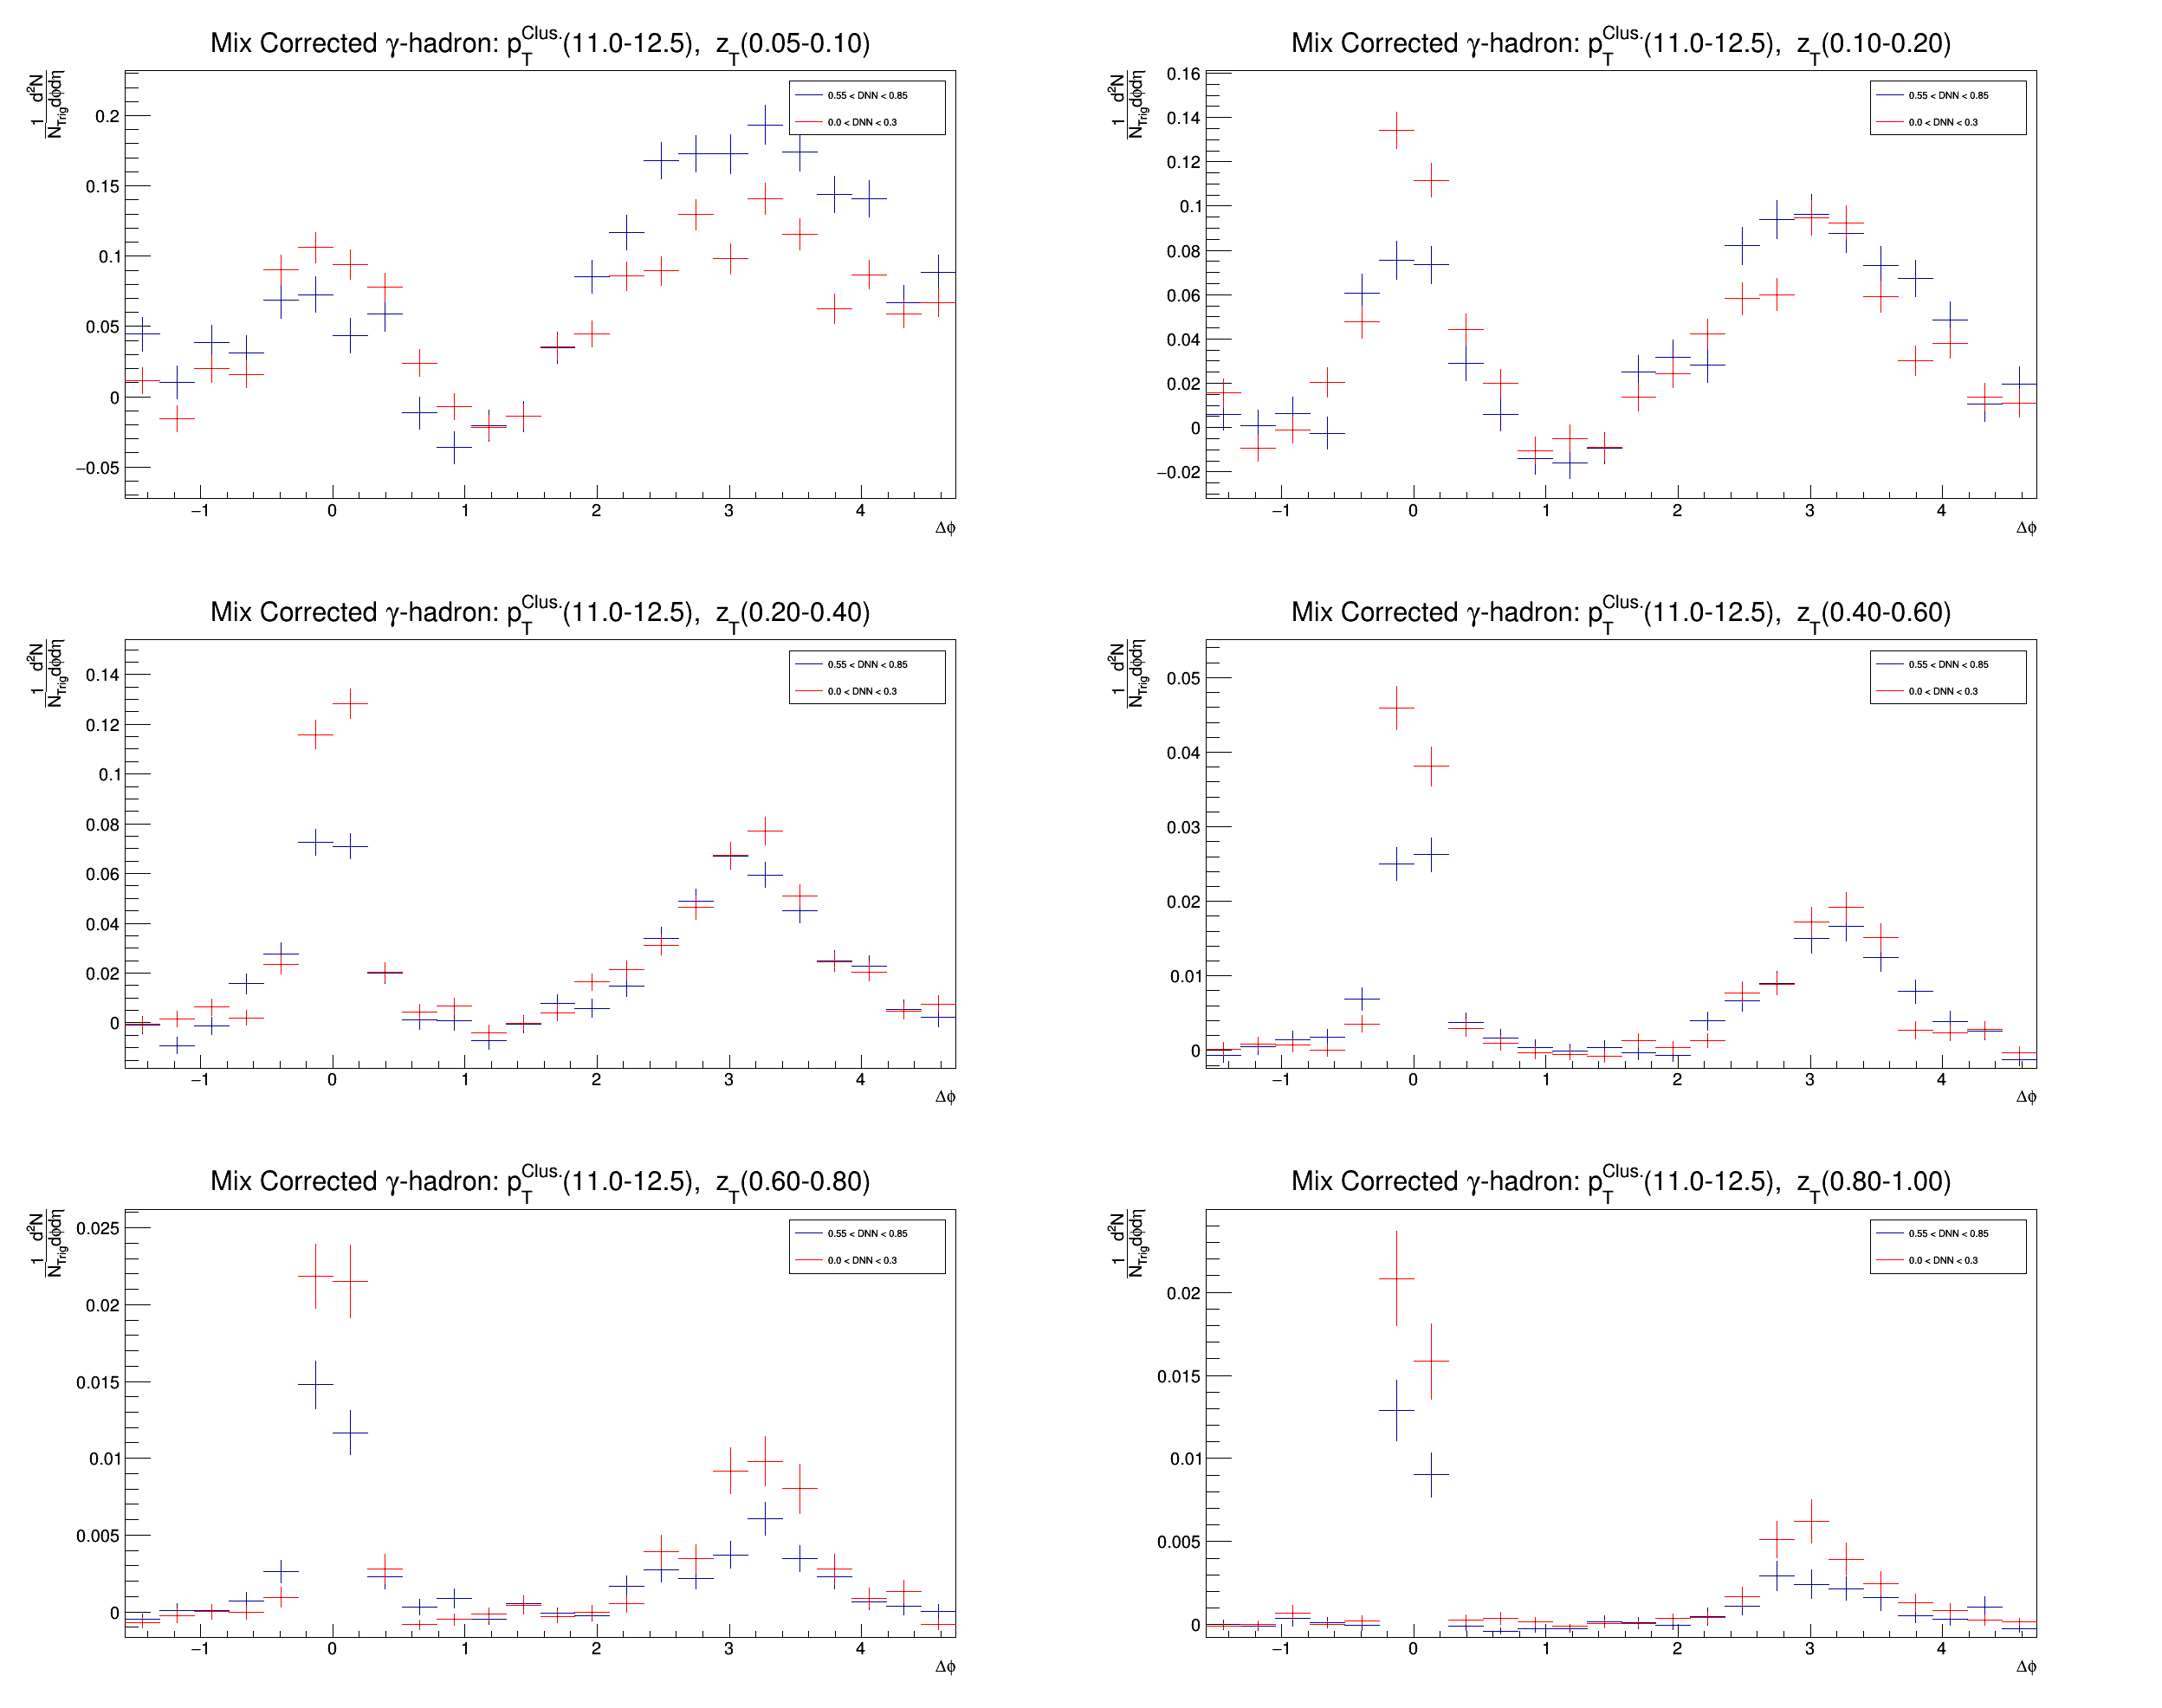

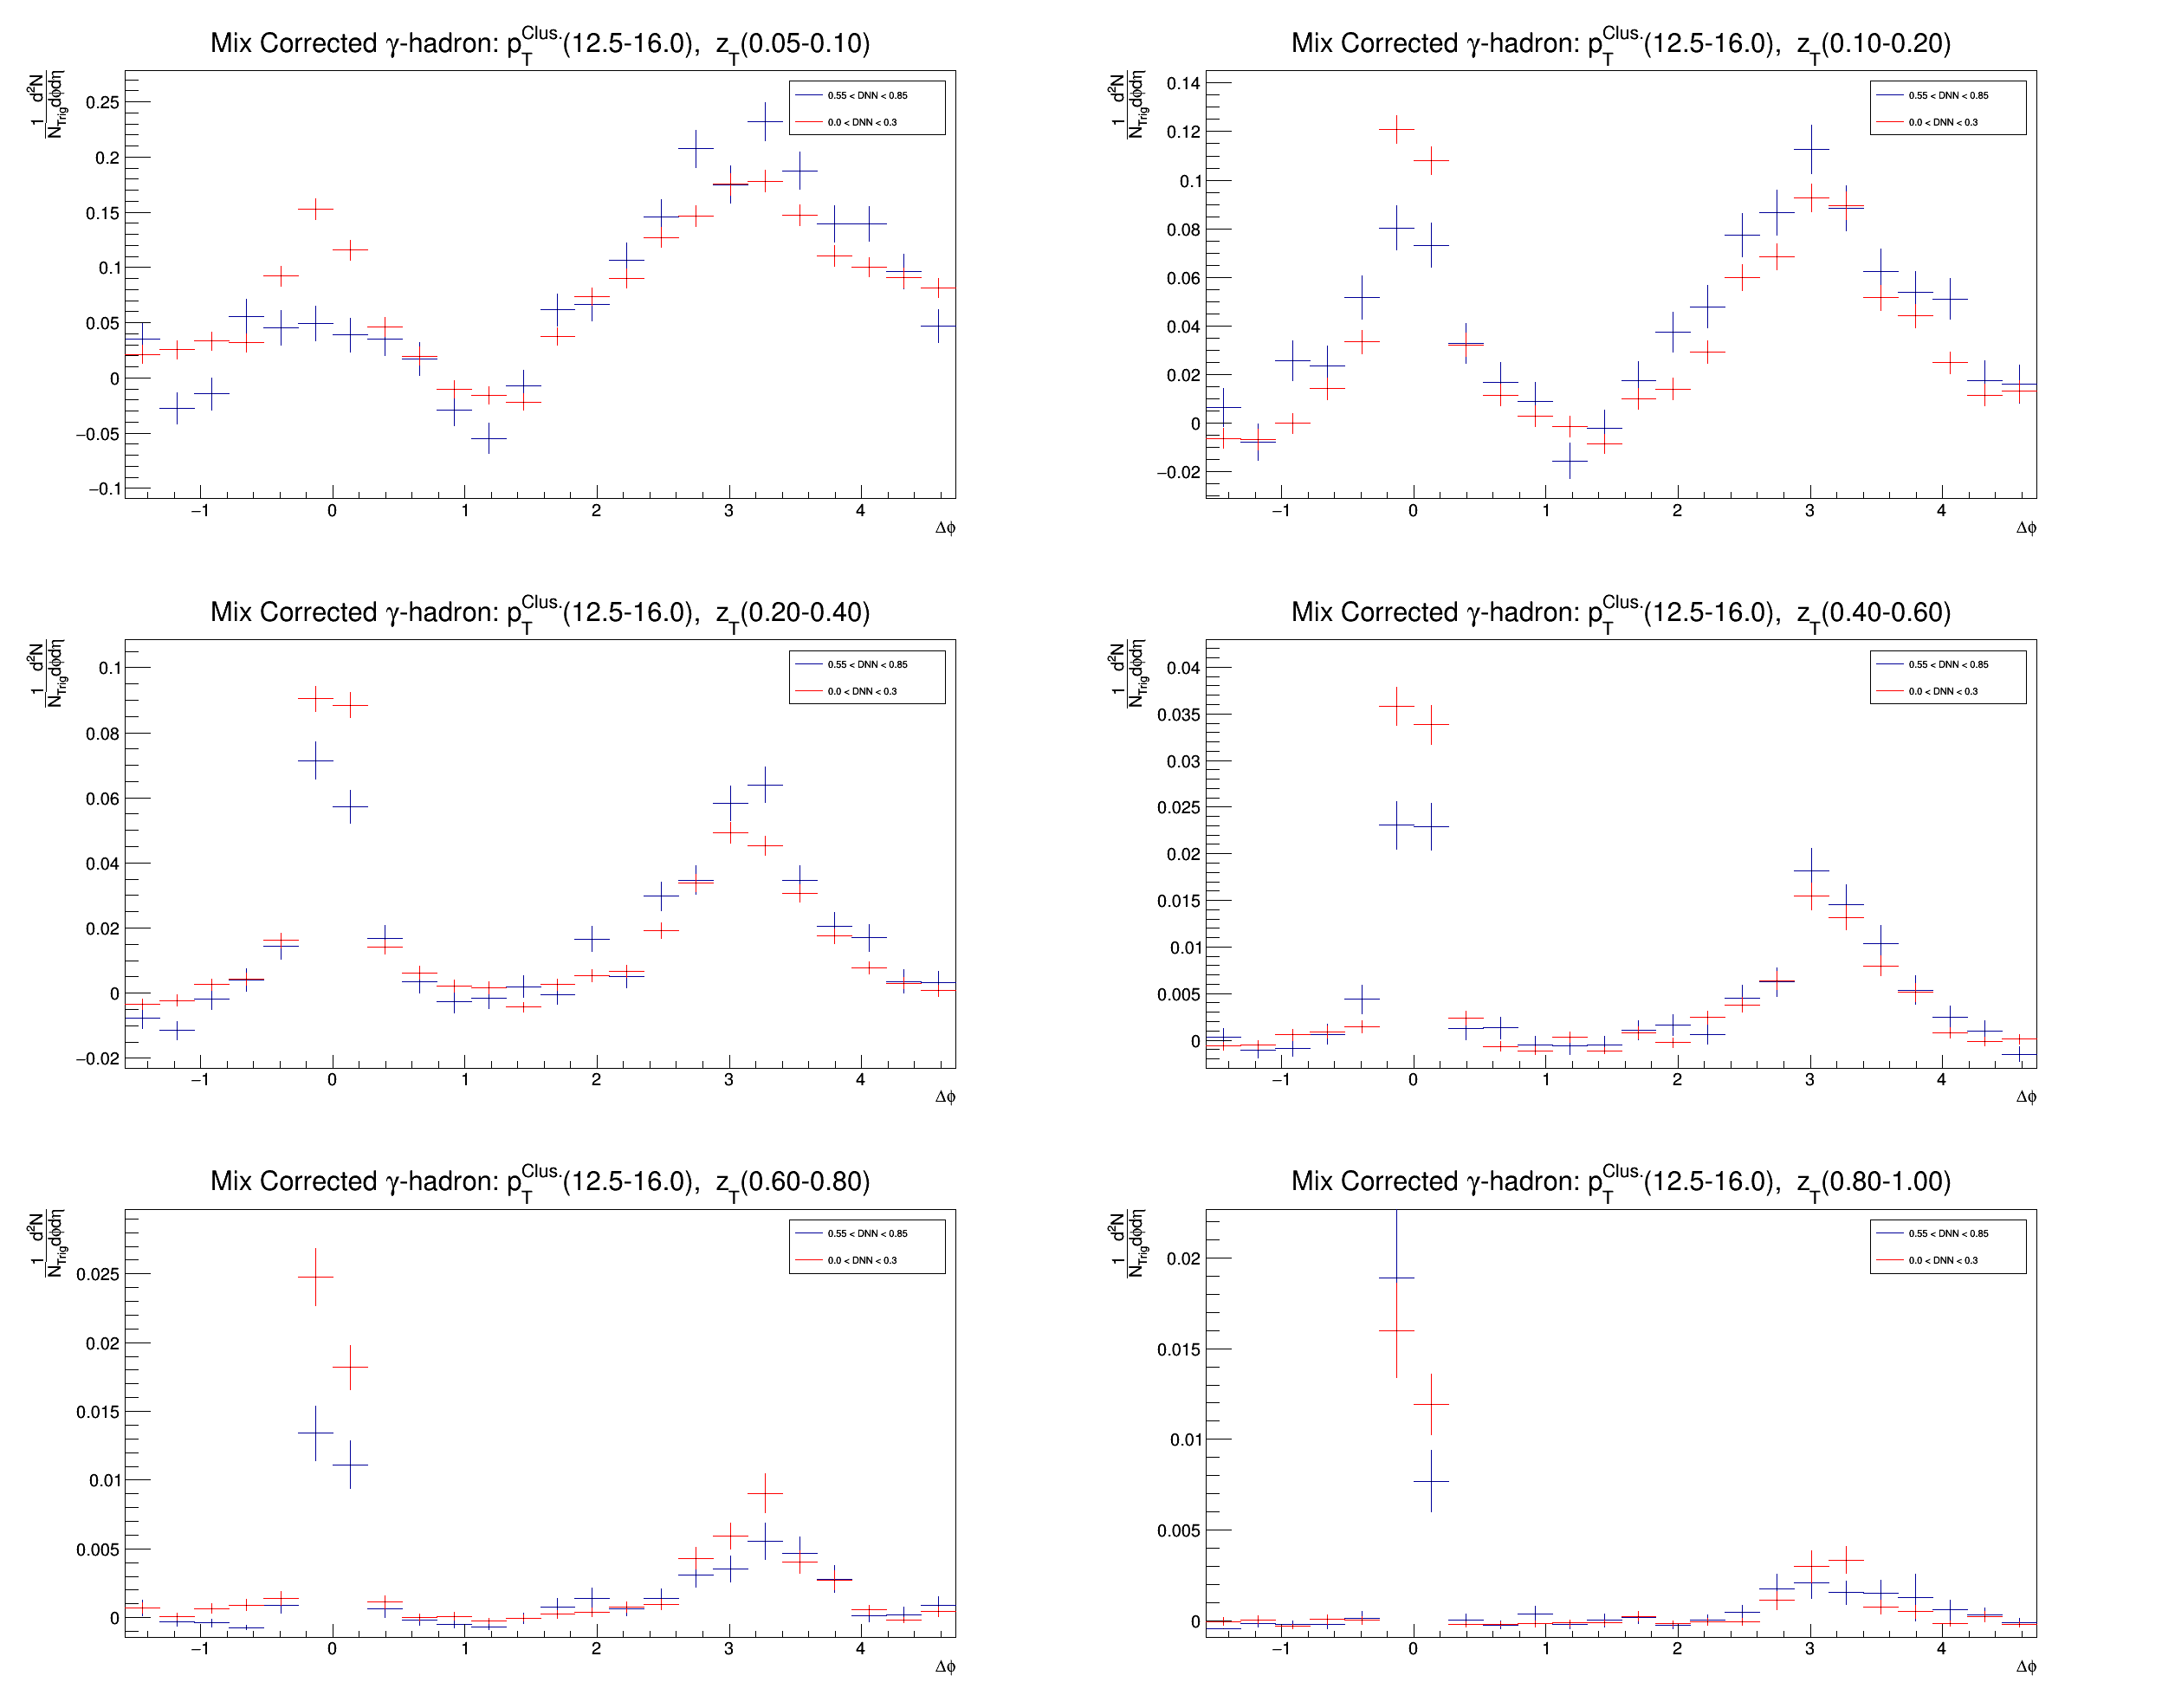

In [24]:
Looping(RootFile,True,False)#Filename,DoZYAM,DoSub